In [1]:
!nvidia-smi

Thu Nov  9 14:48:59 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.90                 Driver Version: 384.90                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
| 27%   28C    P8     9W / 180W |   7308MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:05:00.0 Off |                  N/A |
| 27%   30C    P8     9W / 180W |   7650MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
### Imports ####################################################################
%matplotlib inline
import os
import numpy as np
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, GRU
from typing import Tuple, Callable, List, Optional
from tracker import visuals, extractor, utils, metrics

np.set_printoptions(suppress=True)
Tensor = theano.tensor.Tensor

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:05:00.0)
Using Theano backend.


In [3]:
### File Writers ###############################################################
def write4d(file, array: np.ndarray) -> None:
    for cube in array:
        for matrix in cube:
            for row in matrix:
                for number in row:
                    string = "{0: >6.2f} | ".format(number)
                    string = string.replace("-0.00", "     ")
                    string = string.replace( "0.00",  "    ")
                    file.write(string)
                file.write("\n")
            file.write(("-" * 110) + "\n")
        file.write(("=" * 110) + "\n" + ("=" * 110) + "\n")

def write3d(file, array: np.ndarray) -> None:
    for matrix in array:
        for row in matrix:
            for number in row:
                string = "{0: >6.2f} | ".format(number)
                string = string.replace("-0.00", "     ")
                string = string.replace( "0.00",  "    ")
                file.write(string)
            file.write("\n")
            file.write(("-" * 110) + "\n")
        file.write(("=" * 110) + "\n" + ("=" * 110) + "\n")

def write(filename: str, array: np.ndarray) -> None:
    with open(filename, "w") as file:
        if len(array.shape) == 4:
            write4d(file, array)
        elif len(array.shape) == 3:
            write3d(file, array)
        else:
            file.write(str(array))

In [4]:
### Load in Data ###############################################################
order  = ["phi", "r", "z"]
frame  = pd.read_csv("data/sets/ACTS-MU10-PT1000-T50-PREPARED.gz")
data   = extractor.extract_input(frame, order)
matrix = extractor.extract_output(frame, order)
input_shape  = data.shape[1:]
output_shape = matrix.shape[1:]
print(len(data))
print(input_shape)
print(output_shape)
n = 3
visuals.display_matrices(data[n], matrix[n], order=order, noise=False)

65407
(200, 3)
(200, 52)


,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,[,\,],^,_,`,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,padding
0,1.471408,31.959895,-192.97200,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.483444,71.842967,-371.65000,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2.500341,71.842967,-432.62400,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2.508099,31.959895,-219.80000,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,2.665143,31.959895,-31.34380,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,2.673906,71.842967,-89.13750,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,2.683948,115.818695,-155.34100,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,2.696099,171.809967,-235.49400,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8,2.991512,31.959895,7.66250,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,2.998506,71.842967,81.51560,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [6]:
### Run this cell if you want all events to have max number of hits ############
def regularize_frame(
        frame      : pd.DataFrame,
        num_layers : int,  # How many layers (hits per track).
        num_tracks : int,  # How many tracks per event.
        ) -> pd.DataFrame:
    regular = []
    events = (e for _, e in frame[frame["padding"] == 0].groupby("event_id"))
    for event in events:
        groups = event.groupby("cluster_id")
        tracks = groups.filter(lambda track: num_layers == len(track))
        if num_tracks <= len(pd.unique(tracks["cluster_id"])):
            ids    = tracks["cluster_id"]
            unique = np.sort(pd.unique(ids))
            mapped = dict((v, u) for (u, v) in enumerate(unique))
            tracks = tracks.assign(cluster_id=ids.map(mapped))
            tracks = tracks[tracks["cluster_id"] < num_tracks]
            if num_tracks == len(pd.unique(tracks["cluster_id"])):
                regular.append(tracks)
    return pd.concat(regular)

frame  = regularize_frame(frame, 4, 5)
data   = extractor.extract_input(frame, order)
matrix = extractor.extract_output(frame, order)
input_shape  = data.shape[1:]
output_shape = matrix.shape[1:]
print(input_shape)
print(output_shape)
n = 2
visuals.display_matrices(data[5], matrix[5], order=order, noise=False, padding=False)

(20, 3)
(20, 5)


,phi,r,z,A,B,C,D,E
0,0.359041,31.959895,-43.811200,1,,,,
1,0.364652,71.842967,-2.973750,1,,,,
2,0.370255,115.818695,41.352800,1,,,,
3,0.377614,171.809967,99.881200,1,,,,
4,0.399905,171.809967,10.076600,,1,,,
5,0.411684,115.818695,3.915560,,1,,,
6,0.420956,71.842967,-0.960523,,1,,,
7,0.429232,31.959895,-5.496880,,1,,,
8,0.460835,171.809967,33.715600,,,1,,
9,0.470633,115.818695,19.653100,,,1,,


In [15]:
#### LossFunctionCreator #######################################################
class LossFunctionCreator:
    def __init__(self,
            input_tensor : Tensor,
            input_shape  : Tuple,
            output_shape : Tuple,
            order        : List[str],
            ) -> None:
        """ Initialize the instance variables. """
        self.__name__     = "LossFunctionCreator"
        self.input_tensor = input_tensor
        self.meshgrid     = self.make_meshgrid(output_shape)
        self.input_shape  = input_shape
        self.output_shape = output_shape
        self.order        = order

    def make_meshgrid(self,
            shape : Tuple[int, int],
            ) -> Tensor:
        """
        Create a meshgrid.
        Example for shape (3, 5):
            [[0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4],
             [0, 1, 2, 3, 4]]
        """
        return (T.mgrid[0:shape[0], 0:shape[1]][1])
    
    def combine_with_input_tensor(self,
            input_tensor  : Tensor,
            output_tensor : Tensor,
            ) -> Tensor:
        """
        Return the cartesian product of the input_tensor and the
        output_tensor along the last two axes.
        """
        input_list   = [input_tensor  for _ in range(self.output_shape[-1])]
        output_list  = [output_tensor for _ in range(self.input_shape[-1])]
        input_stack  = T.stack(input_list,  axis=-1)
        output_stack = T.stack(output_list, axis=-2)
        return input_stack * output_stack
    
    def combo_loss(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        """ A loss function. Temporary. """
        input_tensor = self.to_std_dist(self.input_tensor, axis=1)
        true_combo   = self.combine_with_input_tensor(input_tensor, y_true)
        pred_combo   = self.combine_with_input_tensor(input_tensor, y_pred)
        diff_squared = (pred_combo - true_combo)**2
        return diff_squared
    
    def regression_loss(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        input_tensor = self.input_tensor
        # input_tensor = self.to_std_dist(self.input_tensor, axis=1)
        tensor = None
        for i in range(output_shape[1]):  # For each track...
            pred_mask = self.get_track_mask(y_pred, i)
            true_mask = self.get_track_mask(y_true, i)
            
            pred_num_hits = pred_mask.sum(-1).sum(-1) + 2  # Avoid Div(0).
            true_num_hits = true_mask.sum(-1).sum(-1) + 2  # Avoid Div(0).
            
            pred_masked = pred_mask * input_tensor
            true_masked = true_mask * input_tensor
            
            pred_line = self.linear_regression(pred_masked, pred_num_hits)
            true_line = self.linear_regression(true_masked, true_num_hits)
            
            diff   = (pred_line - true_line)**2
            tensor = diff if tensor is None else tensor + diff
        return (tensor / self.output_shape[1])
    
    def to_std_dist(self,
            tensor : Tensor,
            axis   : int,
            ) -> Tensor:
        """
        Transform the tensor's values to be the number of standard deviations
        that the value is from the mean along the specified axis.
        """
        mean = tensor.mean(axis=axis, keepdims=True)
        std  = tensor.std(axis=axis, keepdims=True)
        return (tensor - mean) / std
    
    def softmax(self,
            tensor     : Tensor,
            axis       : Optional[int] = None,
            refinement : float = 1,
            ) -> Tensor:
        """
        Return the softmax of the tensor along the specified axis.
        Higher refinement yields sharper, more accurate results, but also
        tends to yield NaNs for large tensor values.
        """
        exponent = (refinement * tensor).exp()
        return exponent / exponent.sum(axis=axis, keepdims=True)

    def softargmax(self,
            tensor     : Tensor,
            indices    : Tensor,
            axis       : Optional[int] = None,
            refinement : float = 1,
            ) -> Tensor:
        """
        Return the argsoftmax of the tensor along the specified axis.
        Higher refinement yields sharper, more accurate results, but also
        tends to yield NaNs for large tensor values.
        """
        return (self.softmax(tensor, axis, refinement) * indices).sum(axis=axis)
    
    def get_order_mask(self,
            string : str,
            ) -> Tensor:
        """
        Return a mask such that when output is multiplied by this mask,
        only the column corresponding to the *string* category remains.
        """
        mask = np.zeros(len(self.order))
        mask[self.order.index(string)] = 1
        return T.as_tensor_variable(mask)
    
    def get_track_mask(self,
            output   : Tensor,
            track_id : int,
            aref     : int = 32,  # Refinement value for softargmax.
            mref     : int =  4,  # Refinement value for mask values.
            ) -> Tensor:
        """
        Retrieve a tensor containing a mask such that if self.tensor_input
        was multiplied by the mask, the result would be a tensor containing
        the positions of all hits with the specified track_id.
        """
        cats = self.softargmax(output, self.meshgrid, refinement=aref, axis=-1)
        fill = T.fill(cats, track_id)
        diff = (cats - fill)**2
        mask = 1 / (mref * diff).exp()
        mask = mask.reshape((*T.shape(mask), 1))
        return mask
    
    def linear_regression(self,
            tensor : Tensor,
            length : Tensor,
            ) -> Tensor:
        """
        Given a tensor, and the number of hits within the tensor,
        return the two parameters (m, b) of the least squares
        regression line with equation f[x] = (m * x) + b.
        """
        e = 2 * K.common.epsilon()  # Epsilon to avoid division by 0.
        p = (tensor * self.get_order_mask("phi")).sum(-1)
        r = (tensor * self.get_order_mask("r")).sum(-1)  # r values.
        z = (tensor * self.get_order_mask("z")).sum(-1)  # z values.
        
        d = (length * (r**2).sum(-1)) - r.sum(-1)**2 + e  # Denominator.
        m = (length * (r * z).sum(-1) - r.sum(-1) * z.sum(-1)) / d
        b = (z.sum(-1) * (r**2).sum(-1) - r.sum(-1) * (r * z).sum(-1)) / d
        return m #T.stack([m, b]).T
    
    def __call__(self,
            y_true : Tensor,
            y_pred : Tensor,
            ) -> Tensor:
        """ Return a Tensor that measures the loss of a model. """
        return self.regression_loss(y_true, y_pred)
    
A = T.dtensor3("A")
B = T.dtensor3("B")
C = T.dtensor3("C")
D = LossFunctionCreator(A, input_shape, output_shape, order)
E = D(B, C)
F = theano.function([A, B, C], E, on_unused_input='ignore')
# print(theano.printing.debugprint(E))
positions   = data  [0:5]
true_matrix = matrix[0:5]
pred_matrix = np.random.rand(*true_matrix.shape)
pred_matrix = pred_matrix / pred_matrix.sum(-1, keepdims=True)
evaluation = F(positions, true_matrix, pred_matrix).round(2)
print(evaluation)
# write("output4.txt", evaluation)

[ 14.9    6.36  20.93  19.11  23.16]


In [16]:
### Define Model ###############################################################
# Input Layer:
input_layer = Input(
    name  = "Input", 
    shape = input_shape,
)

model_layer = GRU(
    name = "GRU 1",
    return_sequences = True,
    units = 256,
)(input_layer)
model_layer = GRU(
    name = "GRU 2",
    return_sequences = True,
    units = 256,
)(model_layer)
model_layer = GRU(
    name = "GRU 3",
    return_sequences = True,
    units = 256,
)(model_layer)

# Output Layer:
output_layer = Dense(
    name  = "Softmax",
    units = output_shape[1],
    activation = "softmax",
    kernel_initializer = "uniform",
)(model_layer)

model = Model(inputs=input_layer, outputs=output_layer)
loss  = LossFunctionCreator(input_layer, input_shape, output_shape, order)
opt   = keras.optimizers.RMSprop(lr=0.000001)
model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 50, 3)             0         
_________________________________________________________________
GRU 1 (GRU)                  (None, 50, 256)           199680    
_________________________________________________________________
GRU 2 (GRU)                  (None, 50, 256)           393984    
_________________________________________________________________
GRU 3 (GRU)                  (None, 50, 256)           393984    
_________________________________________________________________
Softmax (Dense)              (None, 50, 12)            3084      
Total params: 990,732
Trainable params: 990,732
Non-trainable params: 0
_________________________________________________________________


In [8]:
### Fit Model ##################################################################
histories = model.fit(
    data, 
    matrix, 
    epochs=64, 
    batch_size=50,
    verbose=2, 
    validation_data=(data, matrix)
)
predictions = model.predict(data[0:2])
write("output.txt", predictions)

Train on 59220 samples, validate on 59220 samples
Epoch 1/64
56s - loss: 29473.1560 - acc: 0.1778 - val_loss: 468498.8036 - val_acc: 0.1721
Epoch 2/64
56s - loss: 19732.0228 - acc: 0.1688 - val_loss: 290038.5911 - val_acc: 0.1692
Epoch 3/64
56s - loss: 10246.1756 - acc: 0.1734 - val_loss: 40489.2376 - val_acc: 0.1765
Epoch 4/64
56s - loss: 356833.0331 - acc: 0.1755 - val_loss: 203519.8548 - val_acc: 0.1727
Epoch 5/64
56s - loss: 138782.5225 - acc: 0.1757 - val_loss: 36282.7901 - val_acc: 0.1748
Epoch 6/64
56s - loss: 14255.5526 - acc: 0.1740 - val_loss: 89410.1322 - val_acc: 0.1680
Epoch 7/64
56s - loss: 252808.9929 - acc: 0.1694 - val_loss: 28214.9840 - val_acc: 0.1736
Epoch 8/64
56s - loss: 228898.8181 - acc: 0.1756 - val_loss: 43988.5254 - val_acc: 0.1770
Epoch 9/64
56s - loss: 24837.2212 - acc: 0.1790 - val_loss: 8058.6095 - val_acc: 0.1846
Epoch 10/64
56s - loss: 481700.3600 - acc: 0.1884 - val_loss: 40062.0526 - val_acc: 0.1910
Epoch 11/64
56s - loss: 31908.1773 - acc: 0.1998 - v

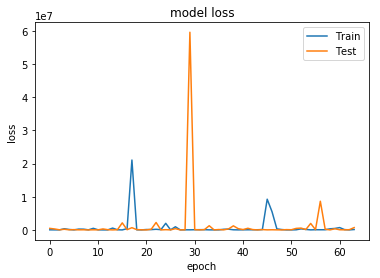

In [9]:
#### Graph Loss ################################################################
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

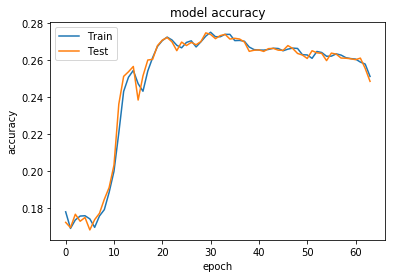

In [10]:
#### Graph Accuracy ############################################################
plt.plot(histories.history['acc'])
plt.plot(histories.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()